In [143]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [144]:
datadir = 'data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv((datadir + '/driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_248.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_248.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_248.jpg,0.0,0.0,0.0,0.000078
1,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_351.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_351.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_351.jpg,0.0,0.0,0.0,0.000080
2,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_461.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_461.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_461.jpg,0.0,0.0,0.0,0.000078
3,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_564.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_564.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_564.jpg,0.0,0.0,0.0,0.000078
4,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/center_2020_03_12_22_04_28_678.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/left_2020_03_12_22_04_28_678.jpg,/Users/aaronspindler/Desktop/SelfDrivingCar/behaviour-cloning/data/IMG/right_2020_03_12_22_04_28_678.jpg,0.0,0.0,0.0,0.000078


In [145]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_03_12_22_04_28_248.jpg,left_2020_03_12_22_04_28_248.jpg,right_2020_03_12_22_04_28_248.jpg,0.0,0.0,0.0,0.000078
1,center_2020_03_12_22_04_28_351.jpg,left_2020_03_12_22_04_28_351.jpg,right_2020_03_12_22_04_28_351.jpg,0.0,0.0,0.0,0.000080
2,center_2020_03_12_22_04_28_461.jpg,left_2020_03_12_22_04_28_461.jpg,right_2020_03_12_22_04_28_461.jpg,0.0,0.0,0.0,0.000078
3,center_2020_03_12_22_04_28_564.jpg,left_2020_03_12_22_04_28_564.jpg,right_2020_03_12_22_04_28_564.jpg,0.0,0.0,0.0,0.000078
4,center_2020_03_12_22_04_28_678.jpg,left_2020_03_12_22_04_28_678.jpg,right_2020_03_12_22_04_28_678.jpg,0.0,0.0,0.0,0.000078


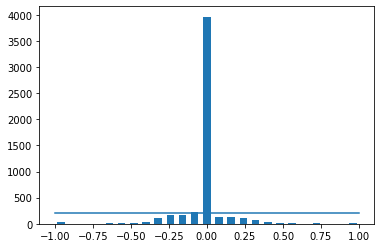

In [146]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total Data 5266
Removed 3778
Remaining 1488


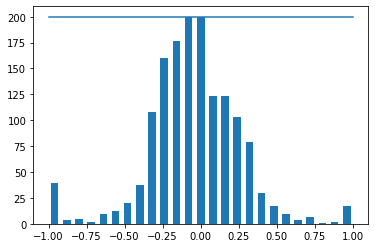

In [147]:
print('Total Data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print('Removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [148]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(datadir + "/" + center.strip())
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [149]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {} \n Valid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1190 
 Valid Samples: 298


Text(0.5, 1.0, 'Validation set')

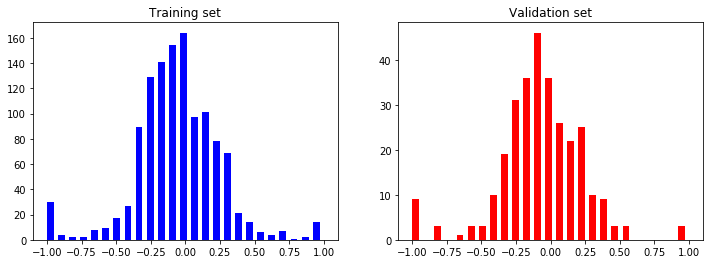

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axs[1].set_title('Validation set')

In [151]:
def image_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

Text(0.5, 1, 'Preprocessed Image')

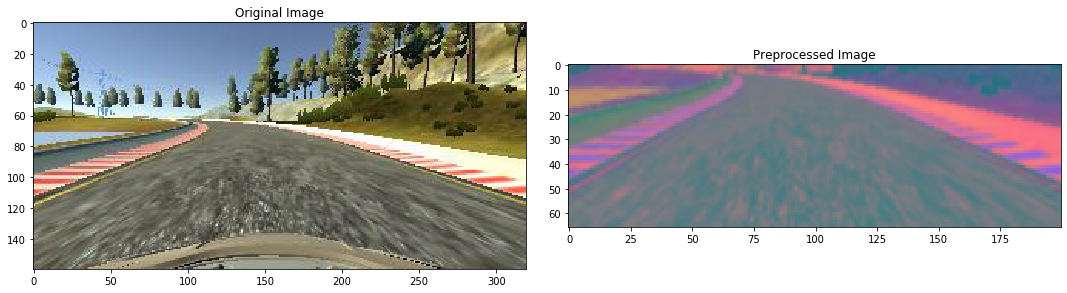

In [152]:
image = image_paths[100]
original = mpimg.imread(image)
preprocessed_image = image_preprocess(image)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [153]:
X_train = np.array(list(map(image_preprocess, X_train)))
X_valid = np.array(list(map(image_preprocess, X_valid)))

(-0.5, 199.5, 65.5, -0.5)

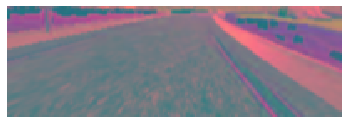

In [154]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')

In [155]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66,200,3), activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [156]:
model = nvidia_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

/Users/aaronspindler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aaronspindler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/Users/aaronspindler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/Users/aaronspindler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/Users/aaronspindler/anaconda3/lib/python3.7/site-packages/ipyker

In [157]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1190 samples, validate on 298 samples
Epoch 1/30
1190/1190 [==============================] - 4s 3ms/step - loss: 0.2869 - val_loss: 0.1025
Epoch 2/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.1064 - val_loss: 0.0973
Epoch 3/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0898 - val_loss: 0.0775
Epoch 4/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0762 - val_loss: 0.0627
Epoch 5/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0644 - val_loss: 0.0528
Epoch 6/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0586 - val_loss: 0.0463
Epoch 7/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0492 - val_loss: 0.0417
Epoch 8/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0461 - val_loss: 0.0371
Epoch 9/30
1190/1190 [==============================] - 3s 3ms/step - loss: 0.0427 - val_loss: 0.0350
Epoch 10/30
1190/1190 [============

Text(0.5, 0, 'Epoch')

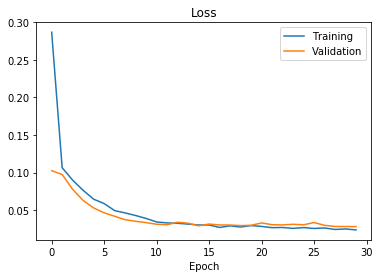

In [158]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [159]:
model.save('model.h5')